<a href="https://colab.research.google.com/github/Dmasong24/DFCC_pksong0517/blob/park/DFCC_eval_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import librosa
#!pip install tensorflow
from tensorflow.keras.models import load_model

In [6]:
model = load_model("drive/MyDrive/DFCC_pksong0517.keras")   # 만들어둔 model 가져오기

In [7]:
# test_label 오름차순 정렬을 위한 숫자 부분 추출 함수
def extract_number_from_test_label(test_label):
    match = re.search(r'\d+', test_label)
    if match:
        return match.group(0)
    return None

In [8]:
# test_labels 불러오기
test_label = pd.read_table('drive/MyDrive/label/test_label.txt', sep='- -', header=None, names=['voice_name','label'])
test_label['voice_number'] = test_label['voice_name'].apply(extract_number_from_test_label)
test_label.sort_values('voice_number', inplace=True)
le = LabelEncoder()
test_labels = le.fit_transform(test_label['label'])

<ipython-input-8-22156bcc61e6>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_label = pd.read_table('drive/MyDrive/label/test_label.txt', sep='- -', header=None, names=['voice_name','label'])


In [9]:
test_label.head()   # eval_label 오름차순 정렬 잘 됐나 확인용

,voice_name,label,voice_number
1773,PSH KDF_E_0001.wav,Fake,0001
561,KSI KDF_E_0002.wav,Real,0002
1580,KSI KDF_E_0003.wav,Fake,0003
1105,YSG KDF_E_0004.wav,Fake,0004
413,CKH KDF_E_0005.wav,Real,0005


In [10]:
test_labels   # eval_labels label encoding 잘 됐나 확인용

array([0, 1, 0, ..., 0, 0, 0])

In [11]:
# test_wav 파일 가져오기
def test_dataset():
    folder = "drive/MyDrive/test"
    dataset = []
    for file in sorted(os.listdir(folder)):
        if 'wav' in file:
            abs_file_path = os.path.join(folder,file)
            data, sr = librosa.load(abs_file_path, sr = 16000)   # data = 진폭값, sr = sample_rate = 16,000(초당 샘플 갯수)
            dataset.append([data, file])

    print("test_Dataset 생성 완료")
    return pd.DataFrame(dataset,columns=['data', 'file'])

test_wav = test_dataset()

test_Dataset 생성 완료


In [12]:
test_wav.head()   # wav 잘 가져왔나 확인용

,data,file
0,"[0.002532959, -0.0017089844, -0.0138549805, -0...",KDF_E_0001.wav
1,"[9.1552734e-05, 0.00015258789, 0.00015258789, ...",KDF_E_0002.wav
2,"[-0.00018310547, 3.0517578e-05, -6.1035156e-05...",KDF_E_0003.wav
3,"[-0.0005187988, -0.0008239746, -0.0011291504, ...",KDF_E_0004.wav
4,"[-0.0010070801, -0.0016479492, -0.0014953613, ...",KDF_E_0005.wav


In [13]:
# train & test 때 사용했던 max_length(=111872)로 test_wav Padding
def set_length_with_padding(data, max_length):
    result = []
    for i in data:
        padded_audio = librosa.util.fix_length(i, size=max_length)
        result.append(padded_audio)
    result = np.array(result)
    return result

test_x = np.array(test_wav.data)
test_x = set_length_with_padding(test_x, 111872)
print("padding 완료")

padding 완료


In [14]:
# MFCC 특징 추출하기
def preprocess_dataset(data):
    mfccs = []
    for i in data:
        extracted_features = librosa.feature.mfcc(y=i,sr=16000,n_mfcc=40)
        mfccs.append(extracted_features)

    return mfccs

test_mfccs = preprocess_dataset(test_x)
test_mfccs = np.array(test_mfccs)
test_mfccs = test_mfccs.reshape(-1, test_mfccs.shape[1], test_mfccs.shape[2], 1)

In [15]:
test_loss, test_acc = model.evaluate(test_mfccs, test_labels)
print(f"테스트 정확도: {test_acc: 3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9334 - loss: 0.5585
테스트 정확도:  0.940500


In [16]:
# 테스트 레이블 전처리 함수
def extract_number_from_test_label(name):
    """파일명에서 숫자 추출 (예: KDF_E_1004 → 1004)"""
    return int(name.split('_')[-1].split('.')[0])

# 테스트 레이블 불러오기
test_label = pd.read_table(
    'drive/MyDrive/label/test_label.txt',
    sep='- -',
    engine='python',
    header=None,
    names=['voice_name','label']
)

# 파일명 전처리 (YSG 등 프리픽스 제거)
test_label['voice_name'] = test_label['voice_name'].str[4:].str.strip()
test_label['voice_number'] = test_label['voice_name'].apply(extract_number_from_test_label)
test_label.sort_values('voice_number', inplace=True)

# 레이블 인코딩
le = LabelEncoder()
test_labels = le.fit_transform(test_label['label'])

# 테스트 데이터 경로 설정
test_data_path = 'drive/MyDrive/test'

# 데이터 저장 리스트 초기화
test_file_names = []
test_x = []
test_y = []

# 음성 데이터 처리 파이프라인
for idx, row in test_label.iterrows():
    file_name = row['voice_name']
    label_encoded = test_labels[idx]  # 인코딩된 라벨 사용[6]

    # 실제 오디오 파일 경로 생성
    wav_path = os.path.join(test_data_path, file_name)

    # 파일 존재 여부 확인 (검색 결과[5][9] 반영)
    if not os.path.exists(wav_path):
        print(f"경고: {wav_path} 파일 없음")
        continue

    try:
        # 오디오 처리 (메모리 엔트리[10]의 CNN 입력 요구사항 반영)
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        test_x.append(mfcc_mean)
        test_y.append(label_encoded)
        test_file_names.append(file_name)

    except Exception as e:
        print(f"{file_name} 처리 실패: {str(e)}")


In [17]:
from tensorflow.keras.utils import to_categorical
# 리스트를 numpy 배열로 변환
X_test = np.array(test_x)

# 라벨 인코딩 (0: fake, 1: real)
le = LabelEncoder()
y_test = le.fit_transform(test_y)

In [18]:
# 예: 파일 이름과 데이터, 라벨을 묶어서 정렬
combined = list(zip(test_file_names, test_mfccs, test_labels))
combined.sort(key=lambda x: x[0])  # 파일 이름 기준 정렬

# 다시 분리
sorted_file_names, sorted_mfccs, sorted_labels = zip(*combined)

# numpy 배열로 변환
sorted_mfccs = np.array(sorted_mfccs)
sorted_labels = np.array(sorted_labels)

In [19]:
y_pred = model.predict(sorted_mfccs)
y_pred_probs = y_pred.flatten()

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(sorted_labels, y_pred_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]

y_pred_classes = (y_pred_probs > optimal_threshold).astype(int)

from sklearn.metrics import accuracy_score
acc = accuracy_score(sorted_labels, y_pred_classes)
print("정렬 후 정확도:", acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step
정렬 후 정확도: 0.945


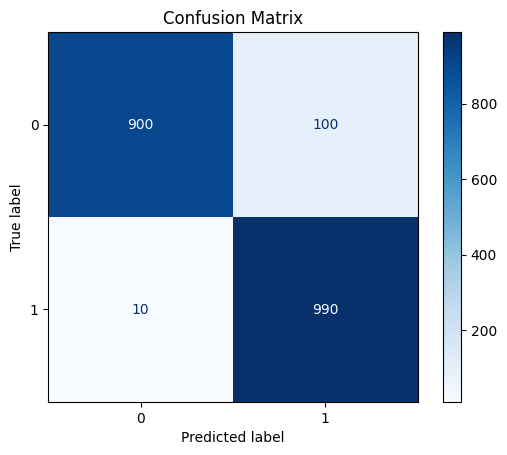

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# 혼동 행렬(Confusion Matrix) 시각화
cm = confusion_matrix(sorted_labels, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [21]:
# label을 sort시킴

# 파일 읽기
with open('drive/MyDrive/label/test_label.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# 번호 추출 함수
def extract_number(line):
    # 예시: YSG KDF_E_1004.wav - - Real
    m = re.search(r'_(\d+)\.wav', line)
    return int(m.group(1)) if m else float('inf')

# 정렬
sorted_lines = sorted(lines, key=extract_number)

# 저장
with open('drive/MyDrive/label/test_label_sorted.txt', 'w', encoding='utf-8') as f:
    f.writelines(sorted_lines)


In [22]:
# test_label_sorted.txt 기준으로 예측 파일 생성
sorted_test_label = pd.read_table(
    'drive/MyDrive/label/test_label_sorted.txt',
    sep='- -',
    engine='python',
    header=None,
    names=['voice_name','label']
)

#test_result 또한 sort시킴
with open('pksong0517_test_result_sorted.txt', 'w') as f:
    for idx, row in sorted_test_label.iterrows():
        # 프리픽스 제거된 파일명 사용
        file_name = row['voice_name'].split(' ', 1)[1].strip()
        pred_label = 'Real' if y_pred_classes[idx] == 1 else 'Fake'
        f.write(f"{file_name} {pred_label}\n")


In [24]:
#sort된 label을 통해 eval.pl 실행
!perl drive/MyDrive/eval.pl pksong0517_test_result_sorted.txt drive/MyDrive/test_label_sorted.txt

============ Results Analysis ===========
Test: pksong0517_test_result_sorted.txt
True: drive/MyDrive/test_label_sorted.txt
Accuracy: 94.50%
Hit: 1890, Total: 2000
